In [42]:
import pandas as pd

col_list = ['news', 'sentiment']
df = pd.read_csv('sentiment_updated_2.csv', usecols=col_list, encoding='utf8')
df

,news,sentiment
0,Bursa Malaysia ended trading day 2021 weak not...,negative
1,Bursa Malaysia broadly higher early trade toda...,negative
2,Bursa Malaysia bucked regional trend close hig...,positive
3,Bursa Malaysia closed lower today amid mixed r...,negative
4,"Bursa Malaysia opened lower morning, bucking r...",negative
...,...,...
329,Malaysia’s economy expected grow 3.7 cent year...,positive
330,Bursa Malaysia turned positive Tuesday broad r...,positive
331,Based corporate announcements news flow Tuesda...,negative
332,Bursa Malaysia extended gains rebound baromete...,positive


## Count phrases using POS patterns

In [84]:
import spacy
nlp = spacy.load("en_core_web_sm")

positive_phrase_freq = {}
negative_phrase_freq = {}

TURNEY_TAG_PATTERNS = [
    [
        {'JJ'},
        {'NN', 'NNS'},
        {}
    ],
    [
        {'RB, RBR, RBS'},
        {'JJ'},
        {'NN', 'NNS'}
    ],
    [
        {'JJ'},
        {'JJ'},
        {'NN', 'NNS'}
    ],
    [
        {'NN', 'NNS'},
        {'JJ'},
        {'NN', 'NNS'}
    ],
    [
        {'RB, RBR, RBS'},
        {'VB, VBD','VBN', 'VBG'},
        {}
    ]
]

def match_turney_pattern(tag1, tag2, tag3):
    for pattern in TURNEY_TAG_PATTERNS:
        if tag1 in pattern[0] and tag2 in pattern[1]:
            if tag3 == None or len(pattern[2]) == 0:
                return True
            return tag3 not in pattern[2]
    return False


def count_phrase_freq(text, is_positive):
    doc = nlp(text)
    num_of_tokens = len(doc)
    second_last_index = num_of_tokens - 3
    for i in range(num_of_tokens):
        if i == num_of_tokens - 1:
            break
        third_tag = None
        if i <= second_last_index:
            third_tag = doc[i+2].tag_
        if match_turney_pattern(doc[i].tag_, doc[i+1].tag_, third_tag):
            phrase = doc[i].lemma_ + ' ' + doc[i+1].lemma_
            try:
                if is_positive:
                    positive_phrase_freq[phrase] += 1
                else:
                    negative_phrase_freq[phrase] += 1
            except KeyError:
                if is_positive:
                    positive_phrase_freq[phrase] = 1
                else:
                    negative_phrase_freq[phrase] = 1


def remove_neutral_phrases(positive_freq, negative_freq):
    p_to_delete = []
    n_to_delete = []
    for i in range(len(positive_freq)):
        p_term = positive_freq[i][0]
        p_freq = positive_freq[i][1]
        for j in range(len(negative_freq)):
            n_term = negative_freq[j][0]
            n_freq = negative_freq[j][1]
            if (p_term == n_term and p_freq > 3 and n_freq > 3) or (p_term == "- day"):
                p_to_delete.append((p_term, p_freq))
                n_to_delete.append((n_term, n_freq))
                break

    for x in p_to_delete:
        try:
            positive_freq.remove(x)
        except:
            pass
    for x in n_to_delete:
        try:
            negative_freq.remove(x)
        except:
            pass
    

for news in df[df.sentiment=='negative'].news:
    count_phrase_freq(news, False)

for news in df[df.sentiment=='positive'].news:
    count_phrase_freq(news, True)

# sort
sorted_positive_freq = sorted(positive_phrase_freq.items(), key=lambda x: x[1], reverse=True)
sorted_negative_freq = sorted(negative_phrase_freq.items(), key=lambda x: x[1], reverse=True)

remove_neutral_phrases(sorted_positive_freq, sorted_negative_freq)
positive_df = pd.DataFrame(sorted_positive_freq, columns=['Phrase', 'Frequency'])
negative_df = pd.DataFrame(sorted_negative_freq, columns=['Phrase', 'Frequency'])

### Top 10 Phrases with Positive Sentiment

In [86]:
positive_df[:10]

,Phrase,Frequency
0,positive territory,5
1,continuous buying,4
2,heavyweight stock,3
3,positive cue,3
4,intraday high,2
5,cautious sentiment,2
6,steady gain,2
7,stimulus package,2
8,upward momentum,2
9,regional peer,2


### Top 10 Phrases with Negative Sentiment

In [85]:
negative_df[:10]

,Phrase,Frequency
0,regional peer,8
1,negative territory,8
2,cautious sentiment,8
3,weak market,7
4,financial service,7
5,consecutive day,7
6,heavyweight stock,7
7,- day,6
8,mixed today,5
9,mixed sentiment,5


### Visualizing top phrases

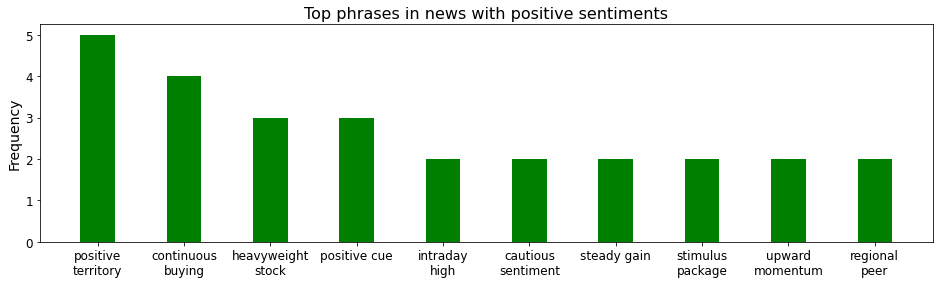

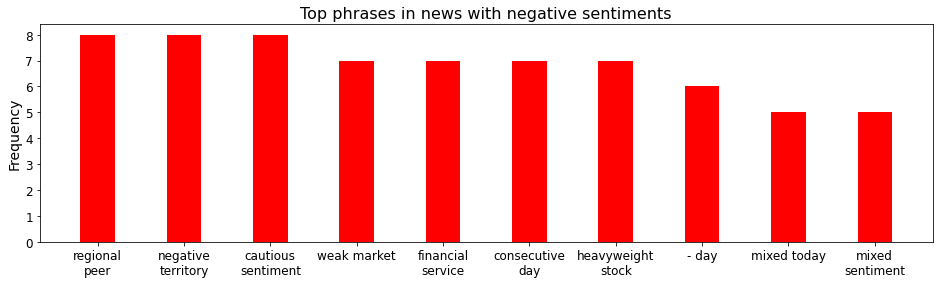

In [103]:
import matplotlib.pyplot as plt
import textwrap

plt.rcParams.update({
    'axes.titlesize' : 16,
    'axes.labelsize' : 14,
    'font.family': 'sans-serif',
    'font.size': 12,
})

def visualize(phrases, frequency, title, color, fname):
    plt.figure(1, figsize=(16, 4))

    phrases = [textwrap.fill(n, 12) for n in phrases]
    plt.bar(phrases, frequency, color=color, width=0.4)

    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()

visualize(positive_df['Phrase'][:10], positive_df['Frequency'][:10], 'Top phrases in news with positive sentiments', 'green', '')
visualize(negative_df['Phrase'][:10], negative_df['Frequency'][:10], 'Top phrases in news with negative sentiments', 'red', '')

In [ ]:
from wordcloud import WordCloud

